# Anomaly Detection

In [1]:
from src.setup import *
%load_ext rpy2.ipython

In [2]:
%%capture --no-stdout err
%%R
library(tidyverse)
require("RPostgreSQL")

## Missing Data

In [3]:
for n in range(7, 10):
    exp1 = 2**n
    a = (22/7) ** exp1 
    b = π ** exp1
    # Compute answer in two "equivalent" ways
    res1 = (a * a) / (b * b)
    res2 = (a / b) * (a / b)
    print(f"n={n}:\n  "
          f"method1: {res1:.3f}\n  "
          f"method2: {res2:.3f}")

n=7:
  method1: 1.109
  method2: 1.109
n=8:
  method1: 1.229
  method2: 1.229
n=9:
  method1: nan
  method2: 1.510


### SQL

In [4]:
# PostgreSQL configuration
def connect_local():
    user = 'cleaning'
    pwd = 'data'
    host = 'localhost'
    port = '5432'  
    db = 'dirty'
    con = psycopg2.connect(database=db, host=host, user=user, password=pwd)
    engine = create_engine(f'postgresql://{user}:{pwd}@{host}:{port}/{db}')
    return con, engine

In [5]:
con, engine = connect_local()
cur = con.cursor()
# Look at table named "missing"
cur.execute("SELECT * FROM missing")
for n, (a, b) in enumerate(cur):
    print(f"{n+1} | {str(a):>4s} | {b}")

1 |  nan | Not number
2 | 1.23 | A number  
3 | None | A null    
4 | 3.45 | Santiago  
5 | 6.78 |           
6 | 9.01 | None


In [6]:
%%R
# Notice NULL is simply ignored in the construction
tibble(val = c(NULL, NA, NaN, 0), 
       str = c("this", "that", NA))

# A tibble: 3 x 2
    val str  
  <dbl> <chr>
1    NA this 
2   NaN that 
3     0 NA   


In [7]:
%%R
drv <- dbDriver("PostgreSQL")
con <- dbConnect(drv, dbname = "dirty",
                 host = "localhost", port = 5432,
                 user = "cleaning", password = "data")
sql <- "SELECT * FROM missing"
data <- tibble(dbGetQuery(con, sql))
data

# A tibble: 6 x 2
       a b           
   <dbl> <chr>       
1 NaN    "Not number"
2   1.23 "A number  "
3  NA    "A null    "
4   3.45 "Santiago  "
5   6.78 "          "
6   9.01  NA         


In [8]:
pd.read_sql("SELECT * FROM missing", engine)

,a,b
0,NaN,Not number
1,1.23,A number
2,NaN,A null
3,3.45,Santiago
4,6.78,
5,9.01,None


### Hierarchical Formats

In [9]:
json.loads('[NaN, null, Infinity]')  # null becomes Python None

[nan, None, inf]

In [10]:
json_data = '''
{"a": {"1": NaN, "2": 1.23, "4": 3.45, "5": 6.78, "6": 9.01},
 "b": {"1": "Not number", "2": "A number", "3": "A null",
       "4": "Santiago", "5": ""}
}'''

In [11]:
pd.read_json(json_data).sort_index()

,a,b
1,NaN,Not number
2,1.23,A number
3,NaN,A null
4,3.45,Santiago
5,6.78,
6,9.01,NaN


In [12]:
data = json.loads(json_data)
rows = {row for dct in data.values() 
            for row in dct.keys()}

for row in sorted(rows):
    for col in data.keys():
        val = data[col].get(row)
        if val is None:
            print(f"Row {row}, Col {col}: Missing")
        elif isinstance(val, float) and math.isnan(val):
            print(f"Row {row}, Col {col}: Not a Number")
        elif not val:
            print(f"Row {row}, Col {col}: Empty value {repr(val)}")

Row 1, Col a: Not a Number
Row 3, Col a: Missing
Row 5, Col b: Empty value ''
Row 6, Col b: Missing


### Sentinels

In [13]:
sorstokken = pd.read_csv('data/sorstokken-no.csv.gz')
sorstokken

,STATION,DATE,TEMP,VISIB,GUST,DEWP
0,1001499999,2019-01-01,39.7,6.2,52.1,30.4
1,1001499999,2019-01-02,36.4,6.2,999.9,29.8
2,1001499999,2019-01-03,36.5,3.3,999.9,35.6
3,1001499999,UNKNOWN,45.6,2.2,22.0,44.8
...,...,...,...,...,...,...
295,1001499999,2019-12-17,40.5,6.2,999.9,39.2
296,1001499999,2019-12-18,38.8,6.2,999.9,38.2
297,1001499999,2019-12-19,45.5,6.1,999.9,42.7
298,1001499999,2019-12-20,51.8,6.2,35.0,41.2


In [14]:
pd.DataFrame([sorstokken.min(), sorstokken.max()])

,STATION,DATE,TEMP,VISIB,GUST,DEWP
0,1001499999,2019-01-01,27.2,1.2,17.1,16.5
1,1001499999,UNKNOWN,88.1,999.9,999.9,63.5


In [15]:
print("Normal max:")
for col in ['VISIB', 'GUST']:
        s = sorstokken[col]
        print(col, s[s < 999.9].max(), 
              "...standard deviation w/ & w/o sentinel:",
              f"{s.std():.1f} / {s[s < 999.9].std():.1f}")

Normal max:
VISIB 6.8 ...standard deviation w/ & w/o sentinel: 254.4 / 0.7
GUST 62.2 ...standard deviation w/ & w/o sentinel: 452.4 / 8.1


In [16]:
sorstokken = pd.read_csv('data/sorstokken-no.csv.gz', 
                         na_values={'DATE': 'UNKNOWN', 
                                    'VISIB': '999.9',
                                    'GUST': '999.9'},
                         parse_dates=['DATE'])
sorstokken.head()

,STATION,DATE,TEMP,VISIB,GUST,DEWP
0,1001499999,2019-01-01,39.7,6.2,52.1,30.4
1,1001499999,2019-01-02,36.4,6.2,NaN,29.8
2,1001499999,2019-01-03,36.5,3.3,NaN,35.6
3,1001499999,NaT,45.6,2.2,22.0,44.8
4,1001499999,2019-01-06,42.5,1.9,NaN,42.5


## Miscoded Data

In [17]:
from src.dermatology import *
(pd.DataFrame(
    [derm.min(), derm.max(), derm.dtypes])
     .T
     .rename(columns={0:'min', 1:'max', 2:'dtype'})
)

,min,max,dtype
erythema,0,3,int64
scaling,0,3,int64
definite borders,0,3,int64
itching,0,3,int64
...,...,...,...
inflammatory monoluclear inflitrate,0,3,int64
band-like infiltrate,0,3,int64
Age,0,75,float64
TARGET,cronic dermatitis,seboreic dermatitis,object


In [18]:
humans = pd.read_csv('data/humans-err.csv')
# random_state for deterministic sample
humans.sample(5, random_state=1)  

,Height,Weight,Hair_Length,Favorite
21492,176.958650,72.604585,14.0,red
9488,169.000221,79.559843,0.0,blue
16933,171.104306,71.125528,5.5,red
12604,174.481084,79.496237,8.1,blue
8222,171.275578,77.094118,14.6,green


In [19]:
humans.Favorite.unique()

array(['red', 'green', 'blue', 'Red', ' red', 'grееn', 'blüe',
       'chartreuse'], dtype=object)

In [20]:
humans.Favorite.value_counts()

red           9576
blue          7961
green         7458
grееn            1
 red             1
blüe             1
chartreuse       1
Red              1
Name: Favorite, dtype: int64

In [21]:
for color in sorted(humans.Favorite.unique()):
    print(f"{color:>10s}", [ord(c) for c in color])

       red [32, 114, 101, 100]
       Red [82, 101, 100]
      blue [98, 108, 117, 101]
      blüe [98, 108, 252, 101]
chartreuse [99, 104, 97, 114, 116, 114, 101, 117, 115, 101]
     green [103, 114, 101, 101, 110]
     grееn [103, 114, 1077, 1077, 110]
       red [114, 101, 100]


In [22]:
humans.loc[humans.Favorite.isin(['Red', ' red']), 'Favorite'] = 'red'
humans.loc[humans.Favorite == 'chartreuse', 'Favorite'] = None
humans.loc[humans.Favorite == 'blüe', 'Favorite'] = 'blue'
humans.loc[humans.Favorite == 'grееn', 'Favorite'] = 'green'
humans.Favorite.value_counts()

red      9578
blue     7962
green    7459
Name: Favorite, dtype: int64

## Fixed Bounds

In [23]:
((humans.Height < 92) | (humans.Height > 213)).any()

False

In [24]:
humans.query('Hair_Length > 120')

,Height,Weight,Hair_Length,Favorite
1984,165.634695,62.979993,127.0,red
8929,175.186061,73.899992,120.6,blue
14673,174.948037,77.644434,130.1,blue
14735,176.385525,68.735397,121.7,green
16672,173.172298,71.814699,121.4,red
17093,169.771111,77.958278,133.2,blue


In [25]:
humans2 = humans.copy()  # Retain prior versions of data set
humans2['Hair_Length'] = humans2.Hair_Length.clip(upper=120)
humans2[humans2.Hair_Length > 119]

,Height,Weight,Hair_Length,Favorite
1984,165.634695,62.979993,120.0,red
4146,173.930107,72.701456,119.6,red
8929,175.186061,73.899992,120.0,blue
9259,179.215974,82.538890,119.4,green
14673,174.948037,77.644434,120.0,blue
14735,176.385525,68.735397,120.0,green
16672,173.172298,71.814699,120.0,red
17093,169.771111,77.958278,120.0,blue


In [26]:
humans2[humans2.Hair_Length == 0]

,Height,Weight,Hair_Length,Favorite
6,177.297182,81.153493,0.0,blue
217,171.893967,68.553526,0.0,blue
240,161.862237,76.914599,0.0,blue
354,172.972247,73.175032,0.0,red
...,...,...,...,...
24834,170.991301,67.652660,0.0,green
24892,177.002643,77.286141,0.0,green
24919,169.012286,74.593809,0.0,blue
24967,169.061308,65.985481,0.0,green


In [27]:
neg_hair = humans2[humans2.Hair_Length < 0]
neg_hair

,Height,Weight,Hair_Length,Favorite
493,167.703398,72.567763,-1.0,blue
528,167.355393,60.276190,-20.7,green
562,172.416114,60.867457,-68.1,green
569,177.644146,74.027147,-5.9,green
...,...,...,...,...
24055,172.831608,74.096660,-13.3,red
24063,172.687488,69.466838,-14.2,green
24386,176.668430,62.984811,-1.0,green
24944,172.300925,72.067862,-24.4,red


In [28]:
%%R -i neg_hair
summary(neg_hair$Hair_Length)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -95.70  -38.08  -20.65  -24.35   -5.60   -0.70 


In [29]:
neg_hair.Hair_Length.describe()

count    118.000000
mean     -24.348305
std       22.484691
min      -95.700000
25%      -38.075000
50%      -20.650000
75%       -5.600000
max       -0.700000
Name: Hair_Length, dtype: float64

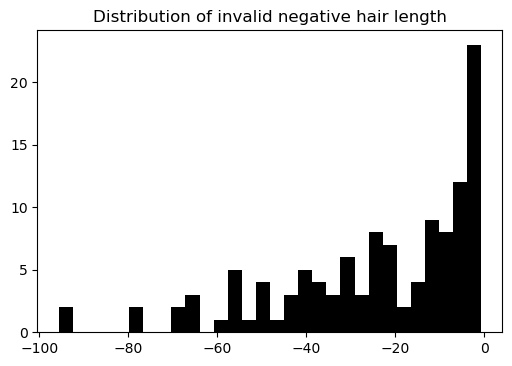

In [30]:
plt.hist(neg_hair.Hair_Length, bins=30)
plt.title("Distribution of invalid negative hair length")
plt.savefig("img/(Ch04)Distribution of invalid negative hair length.png")

In [31]:
neg_hair.Hair_Length.value_counts()

-1.0     19
-41.6     2
-6.8      2
-30.1     2
         ..
-3.3      1
-51.4     1
-25.1     1
-4.8      1
Name: Hair_Length, Length: 93, dtype: int64

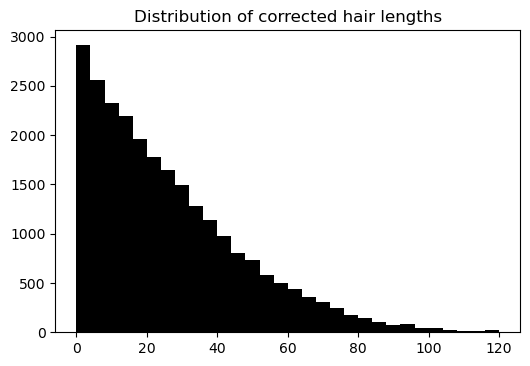

In [32]:
humans3 = humans2.copy()     # Versioned changes to data

# The "sentinel" negative value means missing
humans3.loc[humans3.Hair_Length == -1, 'Hair_Length'] = None

# All other values simply become non-negative
humans3['Hair_Length'] = humans3.Hair_Length.abs()

plt.hist(humans3.Hair_Length, bins=30)
plt.title("Distribution of corrected hair lengths")
plt.savefig("img/(Ch04)Distribution of corrected hair lengths.png")

## Outliers 

### Z-Score

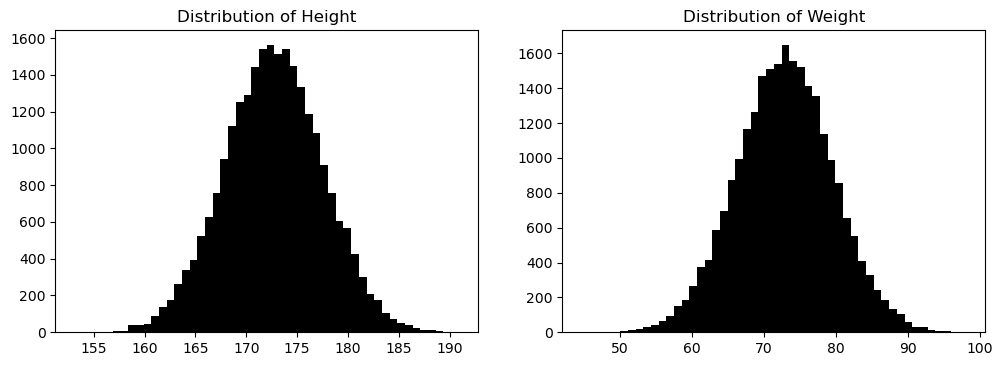

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(humans3.Height, bins=50)
ax2.hist(humans3.Weight, bins=50)
ax1.set_title("Distribution of Height")
ax2.set_title("Distribution of Weight")
fig.savefig("img/(Ch04)Distribution of Height and Weight.png")

In [34]:
from scipy.stats import anderson

for var in ('Height', 'Weight', 'Hair_Length'):
    data = humans3[var][humans3[var].notnull()]
    stat = anderson(data, 'norm').statistic
    print(f"Anderson-Darling statistic for {var:<12s}: {stat:6.2f}")

Anderson-Darling statistic for Height      :   0.24
Anderson-Darling statistic for Weight      :   0.54
Anderson-Darling statistic for Hair_Length : 578.19


In [35]:
humans4 = humans3.copy()

for var in ('Height', 'Weight', 'Hair_Length'):
    zscore = (humans4[var] - humans4[var].mean()) / humans4[var].std()
    humans4[f"zscore_{var}"] = zscore
    
humans4.sample(5, random_state=1)

,Height,Weight,Hair_Length,Favorite,zscore_Height,zscore_Weight,zscore_Hair_Length
21492,176.958650,72.604585,14.0,red,0.880831,-0.042032,-0.568786
9488,169.000221,79.559843,0.0,blue,-0.766210,0.997585,-1.225152
16933,171.104306,71.125528,5.5,red,-0.330758,-0.263109,-0.967294
12604,174.481084,79.496237,8.1,blue,0.368085,0.988078,-0.845397
8222,171.275578,77.094118,14.6,green,-0.295312,0.629028,-0.540656


In [36]:
humans4[humans4.zscore_Height.abs() > 3]

,Height,Weight,Hair_Length,Favorite,zscore_Height,zscore_Weight,zscore_Hair_Length
138,187.708718,86.829633,19.3,green,3.105616,2.084216,-0.320304
174,187.537446,79.893761,37.5,blue,3.070170,1.047496,0.532971
412,157.522316,62.564977,6.8,blue,-3.141625,-1.542673,-0.906345
1162,188.592435,86.155948,53.1,red,3.288506,1.983518,1.264351
...,...,...,...,...,...,...,...
22945,157.293031,44.744929,18.4,red,-3.189077,-4.206272,-0.362499
23039,187.845548,88.554510,6.9,blue,3.133934,2.342037,-0.901657
24244,158.153049,59.725932,13.8,green,-3.011091,-1.967031,-0.578162
24801,189.310696,85.406727,2.3,green,3.437154,1.871531,-1.117320


In [37]:
print("Outlier weight:", (humans4.zscore_Weight.abs() > 3).sum())
print("Outlier hair length:", (humans4.zscore_Hair_Length.abs() > 3).sum())

Outlier weight: 67
Outlier hair length: 285


In [38]:
cond = (
    (humans4.zscore_Height.abs() > 4) |
    (humans4.zscore_Weight.abs() > 4) |
    (humans4.zscore_Hair_Length.abs() > 4.5))
humans4[cond] 

,Height,Weight,Hair_Length,Favorite,zscore_Height,zscore_Weight,zscore_Hair_Length
13971,153.107034,63.155154,4.4,green,-4.055392,-1.454458,-1.018865
14106,157.244415,45.062151,70.7,red,-3.199138,-4.158856,2.089496
22945,157.293031,44.744929,18.4,red,-3.189077,-4.206272,-0.362499


### Interquartile Range

In [39]:
# Function defined but not run in this cell
def show_boxplots(df, cols, whis=1.5):
    # Create as many horizontal plots as we have columns
    fig, axes = plt.subplots(len(cols), 1, figsize=(10, 2*len(cols)))
    # For each one, plot the non-null data inside it
    for n, col in enumerate(cols):
        data = df[col][df[col].notnull()]
        axes[n].set_title(f'{col} Distribution')
        # Extend whiskers to specified IQR multiplier
        axes[n].boxplot(data, whis=whis, vert=False, sym='x')
        axes[n].set_yticks([])
    # Fix spacing of subplots at the end
    fig.tight_layout()
    plt.savefig(f"img/boxplot-{'_'.join(cols)}.png")

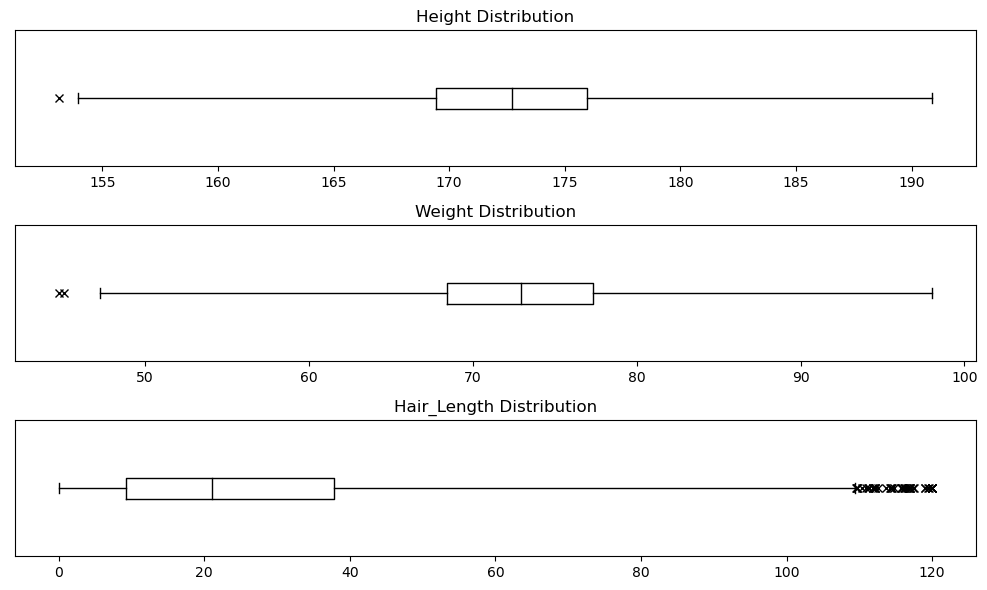

In [40]:
show_boxplots(humans4, ["Height", "Weight", "Hair_Length"], 2.5)

In [41]:
quartiles = (
    humans4[['Height', 'Weight']]
    .quantile(q=[0.25, 0.50, 0.75, 1.0]))
quartiles

,Height,Weight
0.25,169.428884,68.428823
0.50,172.709078,72.930616
0.75,175.953541,77.367039
1.00,190.888112,98.032504


In [42]:
IQR = quartiles.loc[0.75] - quartiles.loc[0.25]
IQR

Height    6.524657
Weight    8.938216
dtype: float64

In [43]:
for col, length in IQR.iteritems():
    high = quartiles.loc[0.75, col] + 2.5*IQR[col]
    low = quartiles.loc[0.25, col] - 2.5*IQR[col]
    print(f"Inliers for {col}: [{low:.3f}, {high:.3f}]")

Inliers for Height: [153.117, 192.265]
Inliers for Weight: [46.083, 99.713]


In [44]:
cond = (
    (humans4.Height > 192.265) |
    (humans4.Height < 153.117) |
    (humans4.Weight > 99.713)  |
    (humans4.Weight < 46.083))
humans4[cond] 

,Height,Weight,Hair_Length,Favorite,zscore_Height,zscore_Weight,zscore_Hair_Length
13971,153.107034,63.155154,4.4,green,-4.055392,-1.454458,-1.018865
14106,157.244415,45.062151,70.7,red,-3.199138,-4.158856,2.089496
22945,157.293031,44.744929,18.4,red,-3.189077,-4.206272,-0.362499


## Multivariate Outliers 

In [45]:
humans5 = humans4[['Height', 'Weight']].copy()
# Convert weight from cm to m
humans5['BMI'] = humans5.Weight / (humans5.Height/100)**2
humans5["zscore_BMI"] = (
    (humans5.BMI - humans5.BMI.mean()) / 
     humans5.BMI.std()
)
humans5

,Height,Weight,BMI,zscore_BMI
0,167.089607,64.806216,23.212279,-0.620410
1,181.648633,78.281527,23.724388,-0.359761
2,176.272800,87.767722,28.246473,1.941852
3,173.270164,81.635672,27.191452,1.404877
...,...,...,...,...
24996,163.952580,68.936137,25.645456,0.618008
24997,164.334317,67.830516,25.117048,0.349063
24998,171.524117,75.861686,25.785295,0.689182
24999,174.949129,71.620899,23.400018,-0.524856


In [46]:
humans5[humans5.zscore_BMI.abs() > 4]

,Height,Weight,BMI,zscore_BMI
21388,165.912597,90.579409,32.905672,4.313253
23456,187.110000,52.920000,15.115616,-4.741383
23457,158.330000,92.780000,37.010755,6.402625
24610,169.082822,47.250297,16.527439,-4.022805


## Exercises

### A Famous Experiment

In [47]:
%%R -o morley
data(morley)
morley %>%
    group_by(`Expt`) %>%
    summarize(Mean = mean(Speed), Count = max(Run))

`summarise()` ungrouping output (override with `.groups` argument)
# A tibble: 5 x 3
   Expt  Mean Count
  <int> <dbl> <int>
1     1  909     20
2     2  856     20
3     3  845     20
4     4  820.    20
5     5  832.    20


### Misspelled Words

In [48]:
%%bash 
similarity David Davin

Levenshtein distance: 1
Similarity ratio: 0.8


In [49]:
%%bash
similarity David Maven

Levenshtein distance: 3
Similarity ratio: 0.4


In [50]:
%%bash
similarity "the quick brown fox jumped" \
           "thee quikc brown fax jumbed"

Levenshtein distance: 5
Similarity ratio: 0.814814814815


In [51]:
names = pd.read_csv('data/humans-names.csv')
names.head()

,Name,Height,Weight
0,James,167.089607,64.806216
1,David,181.648633,78.281527
2,Barbara,176.272800,87.767722
3,John,173.270164,81.635672
4,Michael,172.181037,82.760794


In [52]:
names.Name.value_counts()

Elizabeth    1581
Barbara      1568
Jessica      1547
Jennifer     1534
             ... 
Josep           1
iWlliam         1
Joseeph         1
eJennifer       1
Name: Name, Length: 249, dtype: int64